In [1]:
# import packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pymc.variational.callbacks import CheckParametersConvergence
from patsy import bs, dmatrix
import matplotlib.dates as mdates

# Load in the data

In [2]:
data = pd.read_csv("./student_math_clean.csv")

In [3]:
data.head()

,student_id,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,...,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
0,1,GP,F,18,Urban,Greater than 3,Apart,higher education,higher education,at_home,...,4,3,4,1,1,3,6,5,6,6
1,2,GP,F,17,Urban,Greater than 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,5,3,3,1,1,3,4,5,5,6
2,3,GP,F,15,Urban,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,4,3,2,2,3,3,10,7,8,10
3,4,GP,F,15,Urban,Greater than 3,Living together,higher education,5th to 9th grade,health,...,3,2,2,1,1,5,2,15,14,15
4,5,GP,F,16,Urban,Greater than 3,Living together,secondary education,secondary education,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
data.columns

Index(['student_id', 'school', 'sex', 'age', 'address_type', 'family_size',
       'parent_status', 'mother_education', 'father_education', 'mother_job',
       'father_job', 'school_choice_reason', 'guardian', 'travel_time',
       'study_time', 'class_failures', 'school_support', 'family_support',
       'extra_paid_classes', 'activities', 'nursery_school', 'higher_ed',
       'internet_access', 'romantic_relationship', 'family_relationship',
       'free_time', 'social', 'weekday_alcohol', 'weekend_alcohol', 'health',
       'absences', 'grade_1', 'grade_2', 'final_grade'],
      dtype='object')

# Exploratory Data Analysis

In [5]:
data.dtypes

student_id                int64
school                   object
sex                      object
age                       int64
address_type             object
family_size              object
parent_status            object
mother_education         object
father_education         object
mother_job               object
father_job               object
school_choice_reason     object
guardian                 object
travel_time              object
study_time               object
class_failures            int64
school_support           object
family_support           object
extra_paid_classes       object
activities               object
nursery_school           object
higher_ed                object
internet_access          object
romantic_relationship    object
family_relationship       int64
free_time                 int64
social                    int64
weekday_alcohol           int64
weekend_alcohol           int64
health                    int64
absences                  int64
grade_1 

In [6]:
data.isna().sum()

student_id               0
school                   0
sex                      0
age                      0
address_type             0
family_size              0
parent_status            0
mother_education         0
father_education         0
mother_job               0
father_job               0
school_choice_reason     0
guardian                 0
travel_time              0
study_time               0
class_failures           0
school_support           0
family_support           0
extra_paid_classes       0
activities               0
nursery_school           0
higher_ed                0
internet_access          0
romantic_relationship    0
family_relationship      0
free_time                0
social                   0
weekday_alcohol          0
weekend_alcohol          0
health                   0
absences                 0
grade_1                  0
grade_2                  0
final_grade              0
dtype: int64

Select only the columns that have integer values to look at correlations

In [7]:
int_columns = data.select_dtypes(include=np.number).columns.to_list()

In [8]:
int_columns

['student_id',
 'age',
 'class_failures',
 'family_relationship',
 'free_time',
 'social',
 'weekday_alcohol',
 'weekend_alcohol',
 'health',
 'absences',
 'grade_1',
 'grade_2',
 'final_grade']

In [9]:
corr_df = data[int_columns]
corr_df.corr()

,student_id,age,class_failures,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
student_id,1.000000,0.758057,0.026426,-0.016190,0.003895,0.068811,0.086302,0.095454,-0.088902,0.065966,0.046963,-0.053344,-0.099991
age,0.758057,1.000000,0.243665,0.053940,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.064081,-0.143474,-0.161579
class_failures,0.026426,0.243665,1.000000,-0.044337,0.091987,0.124561,0.136047,0.141962,0.065827,0.063726,-0.354718,-0.355896,-0.360415
family_relationship,-0.016190,0.053940,-0.044337,1.000000,0.150701,0.064568,-0.077594,-0.113397,0.094056,-0.044354,0.022168,-0.018281,0.051363
free_time,0.003895,0.016434,0.091987,0.150701,1.000000,0.285019,0.209001,0.147822,0.075733,-0.058078,0.012613,-0.013777,0.011307
social,0.068811,0.126964,0.124561,0.064568,0.285019,1.000000,0.266994,0.420386,-0.009577,0.044302,-0.149104,-0.162250,-0.132791
weekday_alcohol,0.086302,0.131125,0.136047,-0.077594,0.209001,0.266994,1.000000,0.647544,0.077180,0.111908,-0.094159,-0.064120,-0.054660
weekend_alcohol,0.095454,0.117276,0.141962,-0.113397,0.147822,0.420386,0.647544,1.000000,0.092476,0.136291,-0.126179,-0.084927,-0.051939
health,-0.088902,-0.062187,0.065827,0.094056,0.075733,-0.009577,0.077180,0.092476,1.000000,-0.029937,-0.073172,-0.097720,-0.061335
absences,0.065966,0.175230,0.063726,-0.044354,-0.058078,0.044302,0.111908,0.136291,-0.029937,1.000000,-0.031003,-0.031777,0.034247


### Correlation Map

<Axes: >

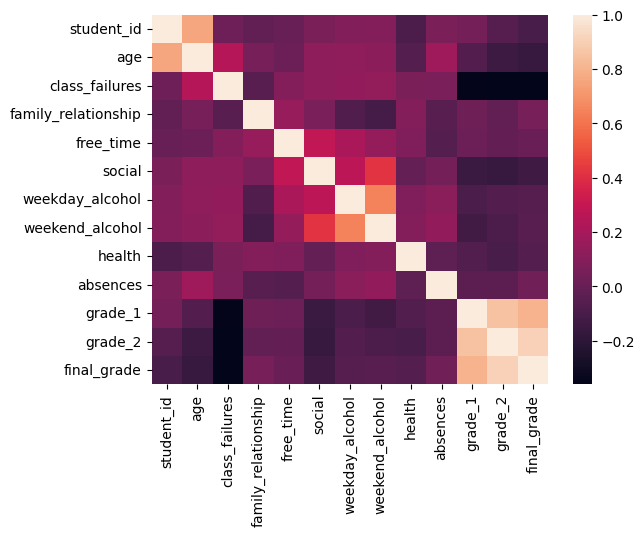

In [10]:
sns.heatmap(corr_df.corr())

grade_1, grade_2, and final_grade are highly correlated

### Categorical Variable EDA

In [11]:
cat_columns = data.select_dtypes(include='object').columns.to_list()

In [12]:
for col in cat_columns:
    print(data[col].value_counts())
    print('\n')

GP    349
MS     46
Name: school, dtype: int64


F    208
M    187
Name: sex, dtype: int64


Urban    307
Rural     88
Name: address_type, dtype: int64


Greater than 3             281
Less than or equal to 3    114
Name: family_size, dtype: int64


Living together    354
Apart               41
Name: parent_status, dtype: int64


higher education                 131
5th to 9th grade                 103
secondary education               99
primary education (4th grade)     59
none                               3
Name: mother_education, dtype: int64


5th to 9th grade                 115
secondary education              100
higher education                  96
primary education (4th grade)     82
none                               2
Name: father_education, dtype: int64


other       141
services    103
at_home      59
teacher      58
health       34
Name: mother_job, dtype: int64


other       217
services    111
teacher      29
at_home      20
health       18
Name: father_job, dtype: in

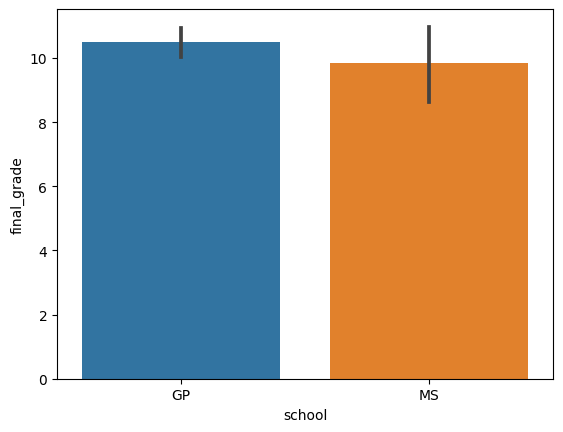

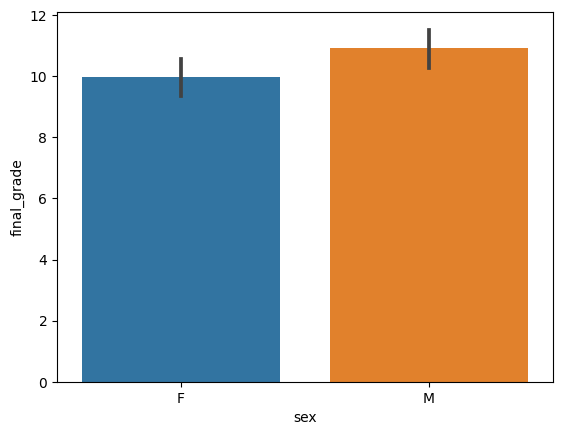

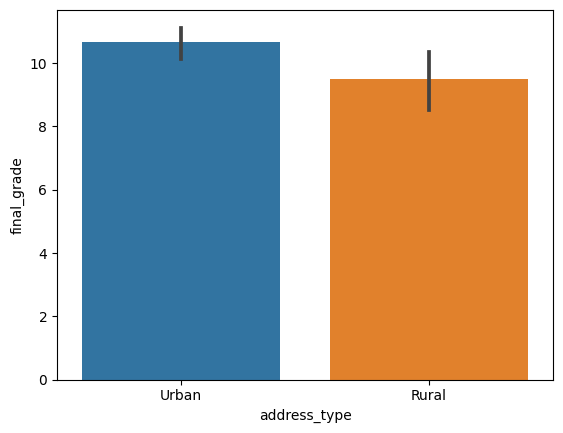

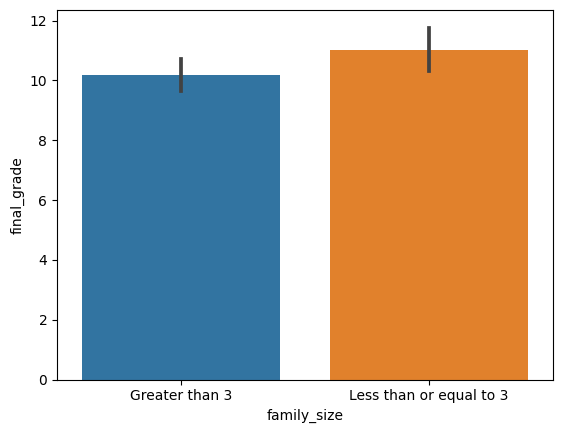

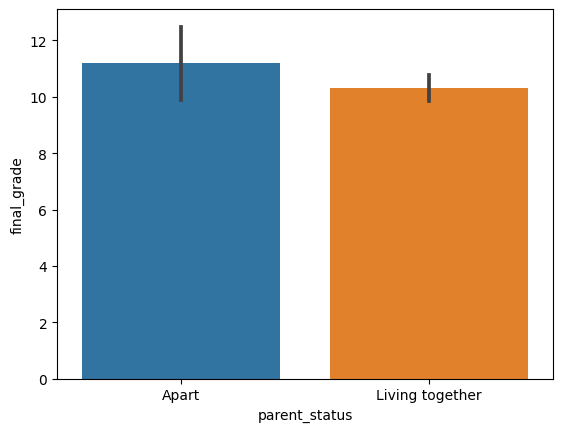

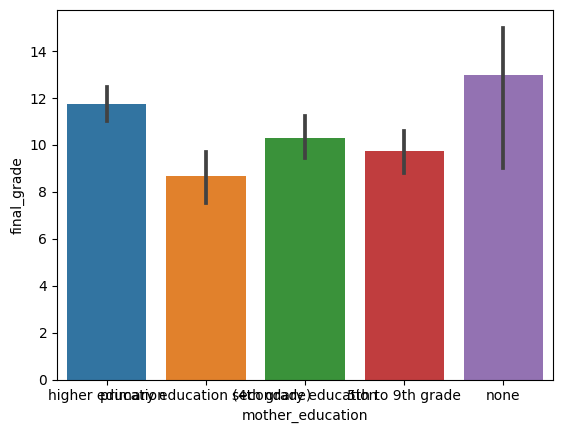

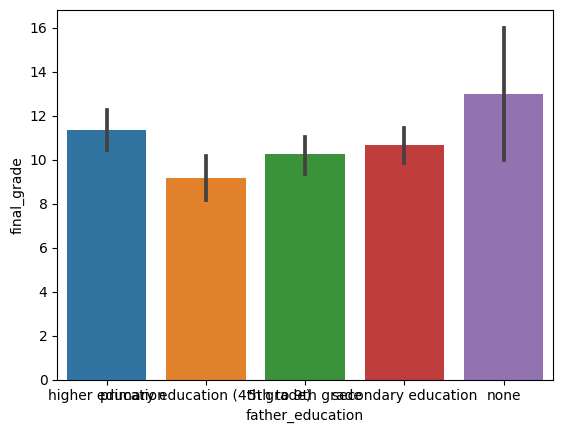

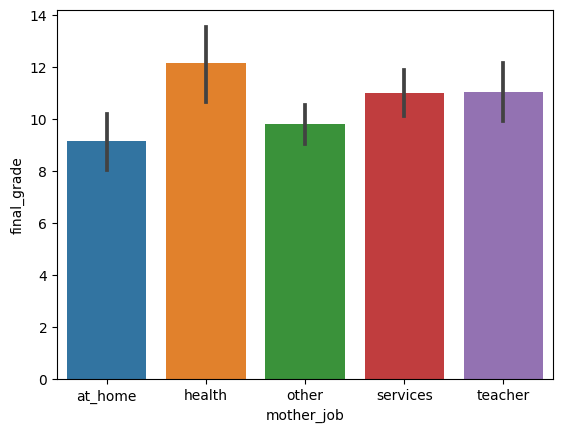

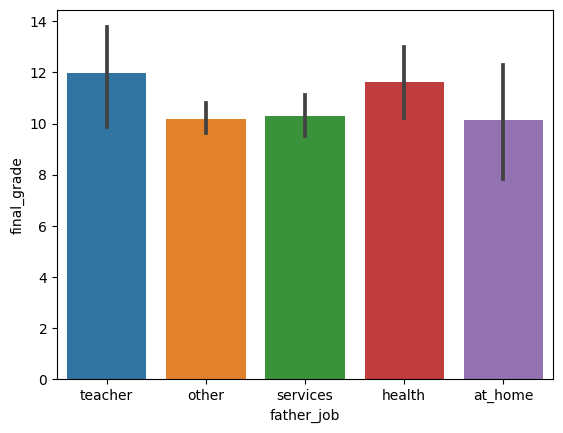

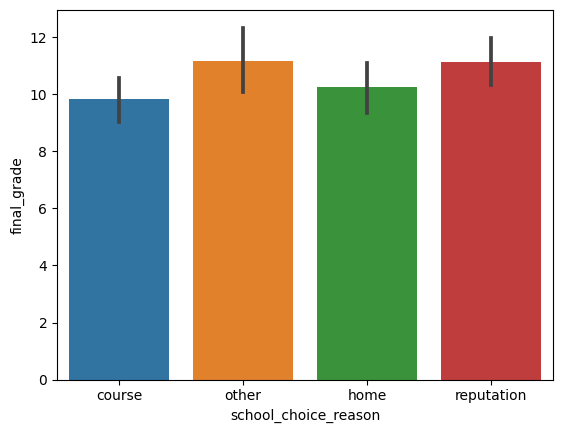

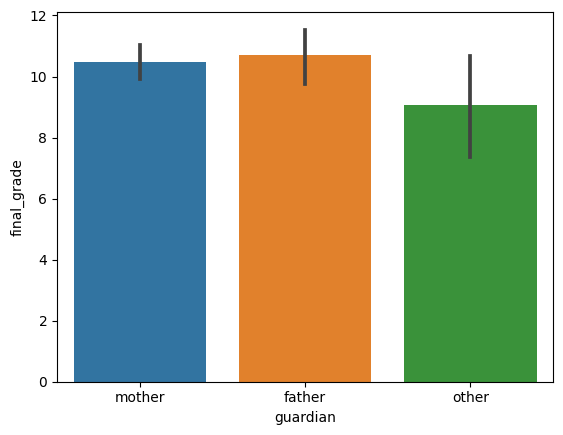

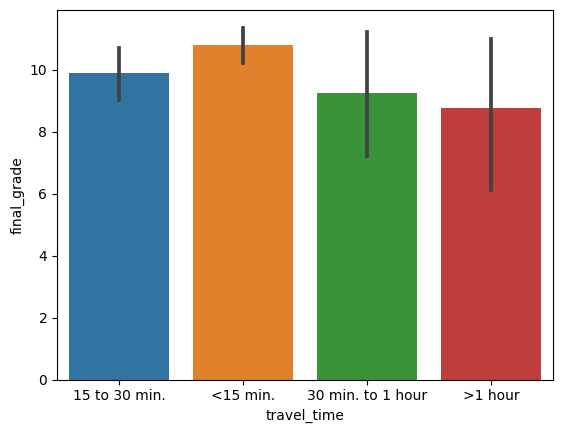

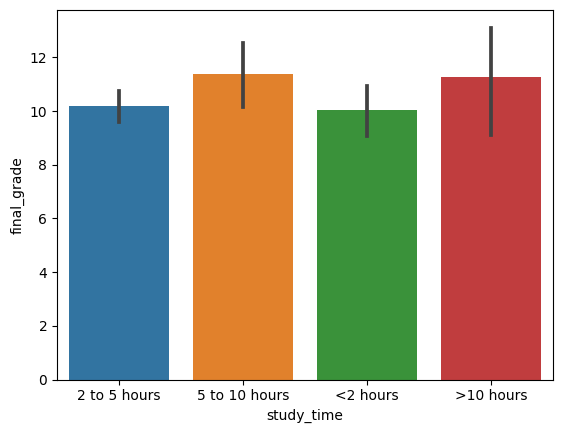

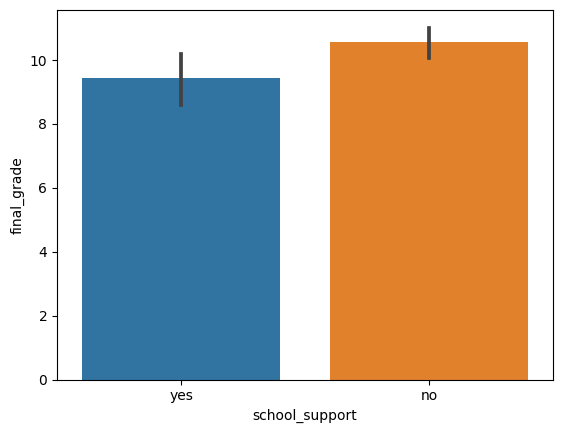

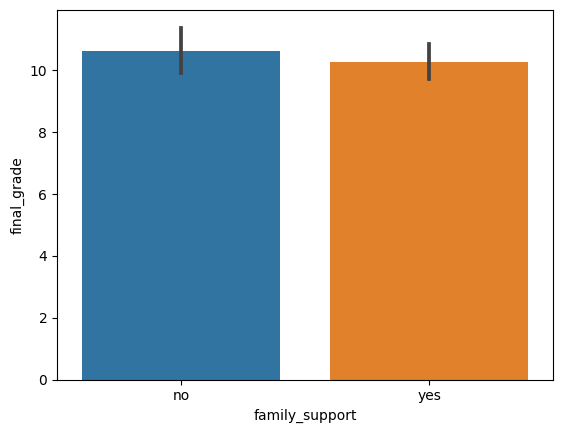

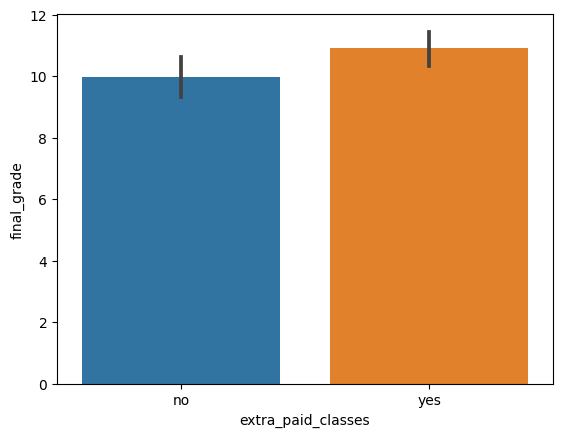

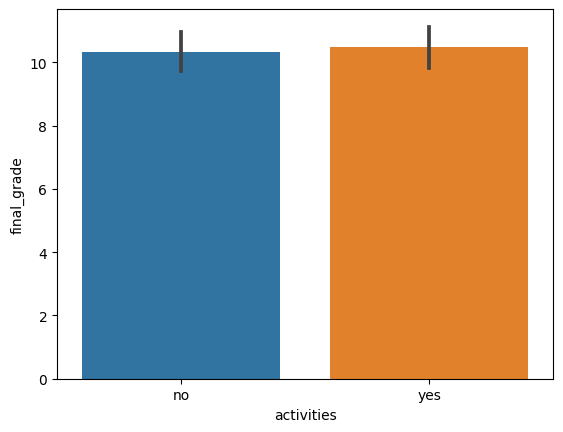

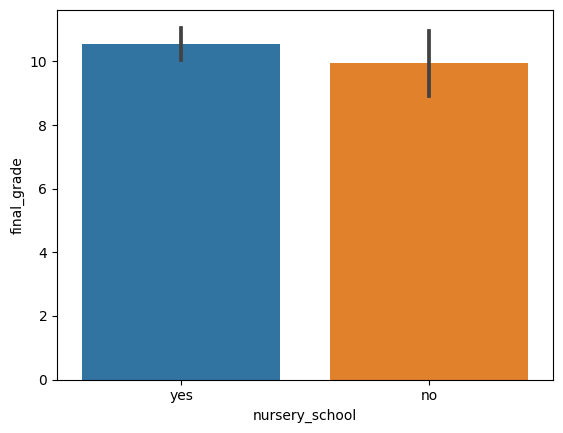

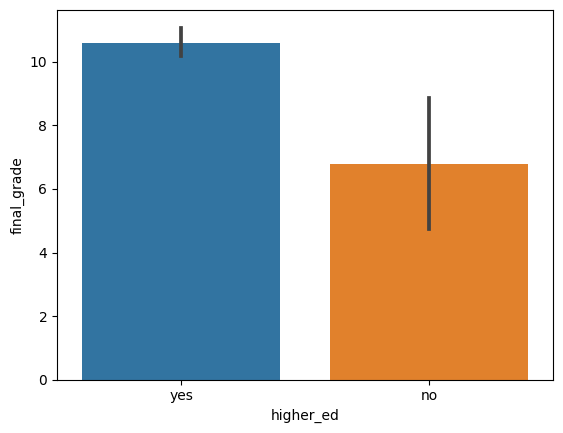

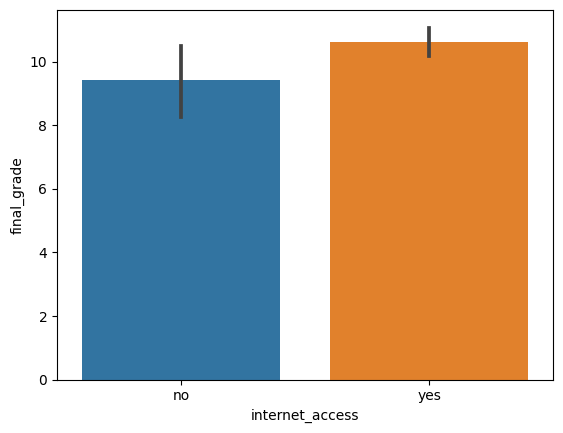

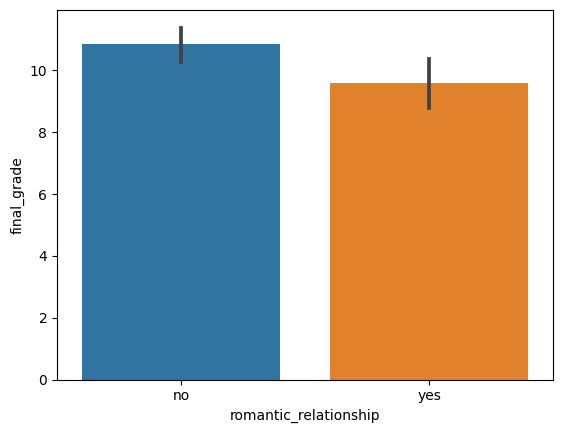

In [13]:
for col in cat_columns:
    sns.barplot(data, x = data[col], y= data['final_grade'])
    plt.show()

# Dummy Coding

In [14]:
clean = data.copy(deep=True)

In [15]:
replace_map = {'school_support': {'yes':1,'no': 0},
               'family_support': {'yes':1,'no': 0},
               'extra_paid_classes': {'yes':1,'no': 0},
               'activities': {'yes':1,'no': 0},
               'nursery_school': {'yes':1,'no': 0},
               'higher_ed': {'yes':1,'no': 0},
               'internet_access': {'yes':1,'no': 0},
               'romantic_relationship': {'yes':1,'no': 0}}

In [16]:
clean = clean.replace(replace_map)

In [17]:
clean.dtypes

student_id                int64
school                   object
sex                      object
age                       int64
address_type             object
family_size              object
parent_status            object
mother_education         object
father_education         object
mother_job               object
father_job               object
school_choice_reason     object
guardian                 object
travel_time              object
study_time               object
class_failures            int64
school_support            int64
family_support            int64
extra_paid_classes        int64
activities                int64
nursery_school            int64
higher_ed                 int64
internet_access           int64
romantic_relationship     int64
family_relationship       int64
free_time                 int64
social                    int64
weekday_alcohol           int64
weekend_alcohol           int64
health                    int64
absences                  int64
grade_1 

# Clean data

In [18]:
dummies_2 = pd.get_dummies(clean, dtype=int)
dummies_2.head()

,student_id,age,class_failures,school_support,family_support,extra_paid_classes,activities,nursery_school,higher_ed,internet_access,...,guardian_mother,guardian_other,travel_time_15 to 30 min.,travel_time_30 min. to 1 hour,travel_time_<15 min.,travel_time_>1 hour,study_time_2 to 5 hours,study_time_5 to 10 hours,study_time_<2 hours,study_time_>10 hours
0,1,18,0,1,0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0
1,2,17,0,0,1,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
2,3,15,3,1,0,1,0,1,1,1,...,1,0,0,0,1,0,1,0,0,0
3,4,15,0,0,1,1,1,1,1,1,...,1,0,0,0,1,0,0,1,0,0
4,5,16,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0


Cleaning odd characters in column names

In [19]:
dummies_2.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
dummies_2.rename(columns=lambda x: x.replace('(', ''), inplace=True)
dummies_2.rename(columns=lambda x: x.replace(')', ''), inplace=True)
dummies_2.rename(columns=lambda x: x.replace('<', 'less_'), inplace=True)
dummies_2.rename(columns=lambda x: x.replace('>', 'greater_'), inplace=True)

In [20]:
dummies_2.head()

,student_id,age,class_failures,school_support,family_support,extra_paid_classes,activities,nursery_school,higher_ed,internet_access,...,guardian_mother,guardian_other,travel_time_15_to_30_min.,travel_time_30_min._to_1_hour,travel_time_less_15_min.,travel_time_greater_1_hour,study_time_2_to_5_hours,study_time_5_to_10_hours,study_time_less_2_hours,study_time_greater_10_hours
0,1,18,0,1,0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0
1,2,17,0,0,1,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
2,3,15,3,1,0,1,0,1,1,1,...,1,0,0,0,1,0,1,0,0,0
3,4,15,0,0,1,1,1,1,1,1,...,1,0,0,0,1,0,0,1,0,0
4,5,16,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0


In [21]:
dummies_2.columns

Index(['student_id', 'age', 'class_failures', 'school_support',
       'family_support', 'extra_paid_classes', 'activities', 'nursery_school',
       'higher_ed', 'internet_access', 'romantic_relationship',
       'family_relationship', 'free_time', 'social', 'weekday_alcohol',
       'weekend_alcohol', 'health', 'absences', 'grade_1', 'grade_2',
       'final_grade', 'school_GP', 'school_MS', 'sex_F', 'sex_M',
       'address_type_Rural', 'address_type_Urban',
       'family_size_Greater_than_3', 'family_size_Less_than_or_equal_to_3',
       'parent_status_Apart', 'parent_status_Living_together',
       'mother_education_5th_to_9th_grade',
       'mother_education_higher_education', 'mother_education_none',
       'mother_education_primary_education_4th_grade',
       'mother_education_secondary_education',
       'father_education_5th_to_9th_grade',
       'father_education_higher_education', 'father_education_none',
       'father_education_primary_education_4th_grade',
       'fath

# Variational Inference

Drop student_id

In [22]:
mean = dummies_2.mean()
std = dummies_2.std()
dummies_2 = dummies_2.drop('student_id', axis=1)

## Splitting Integer and Categorical Data Sets to Apply Different Priors

Z Standardizing

In [23]:
new_int_cols = int_columns[1:]
dummies_2_int = dummies_2[new_int_cols]

# standardize integer predictors
mean = dummies_2_int.mean()
std = dummies_2_int.std()

dummies_2_int = (dummies_2_int - mean) / std

In [24]:
dummies_2_int

,age,class_failures,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
0,1.021751,-0.449374,0.062115,-0.235711,0.800464,-0.540014,-1.002518,-0.398784,0.036378,-1.780209,-1.253202,-0.963712
1,0.238078,-0.449374,1.177367,-0.235711,-0.097784,-0.540014,-1.002518,-0.398784,-0.213525,-1.780209,-1.519053,-0.963712
2,-1.329268,3.584777,0.062115,-0.235711,-0.996032,0.582646,0.550402,-0.398784,0.536185,-1.177653,-0.721500,-0.090624
3,-1.329268,-0.449374,-1.053136,-1.236851,-0.996032,-0.540014,-1.002518,1.039751,-0.463428,1.232570,0.873607,1.000735
4,-0.545595,-0.449374,0.062115,-0.235711,-0.996032,-0.540014,-0.226058,1.039751,-0.213525,-1.478931,-0.189797,-0.090624
...,...,...,...,...,...,...,...,...,...,...,...,...
390,2.589096,2.240060,1.177367,1.766567,0.800464,2.827967,2.103322,0.320484,0.661137,-0.575098,-0.455649,-0.308896
391,0.238078,-0.449374,-2.168388,0.765428,1.698712,1.705307,1.326862,-1.118051,-0.338477,0.931292,1.405309,1.219007
392,3.372769,3.584777,1.177367,1.766567,-0.097784,1.705307,0.550402,-0.398784,-0.338477,-0.273820,-0.721500,-0.745440
393,1.021751,-0.449374,0.062115,0.765428,-1.894280,1.705307,1.326862,1.039751,-0.713332,0.027458,0.341905,-0.090624


In [25]:
dummies_2_cat = dummies_2.drop(new_int_cols, axis=1)
dummies_2_cat.head()

# drop response
dummies_2_int = dummies_2_int.drop('final_grade', axis=1)

In [26]:
X_int = dummies_2_int
k=X_int.shape[1]
n=X_int.shape[0]
Ones = np.ones(n).reshape((n,1))
X_int = np.concatenate((Ones, X_int), axis = 1) #this is for the intercept
print(X_int.shape)

(395, 12)


In [27]:
X_cat = dummies_2_cat
k_cat = X_cat.shape[1]
n_cat = X_cat.shape[0]
Ones_cat = np.ones(n_cat).reshape((n_cat,1))
X_cat = np.concatenate((Ones_cat, X_cat), axis = 1)

Response - cleaning and Z Standardizing

In [28]:
response = pd.read_csv('./student_math_clean.csv')
response = response['final_grade']
response_mean = response.mean()
response_std = response.std()
response = response-response_mean/response_std

## Creating a Model

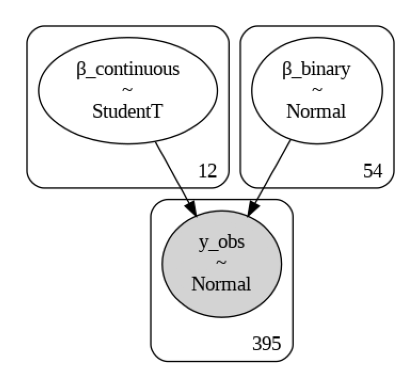

In [29]:
with pm.Model() as grade_model:
    β_continuous = pm.StudentT('β_continuous', nu=3, mu=0, lam=1, shape=X_int.shape[1])
    β_binary = pm.Normal('β_binary', mu=0, sigma=1, shape=X_cat.shape[1])

    # Combine beta coefficients
    β = pm.math.concatenate([β_continuous, β_binary])

    # Calculate the linear combination
    μ = pm.math.dot(X_int, β[:X_int.shape[1]]) + pm.math.dot(X_cat, β[X_int.shape[1]:])

    # Define the likelihood (normal distribution for continuous response)
    y_obs = pm.Normal('y_obs', mu=μ, sigma=1, observed=response)


g = pm.model_to_graphviz(grade_model)
g.render("grade_model", format="png", cleanup=True)

img = plt.imread("grade_model.png")
plt.imshow(img)
plt.axis('off')
plt.show()

## Using ADVI

In [30]:
with grade_model:
    # Variational fit with ADVI optimization
    advi_fit = pm.fit(100000, method='advi', random_seed = 123)

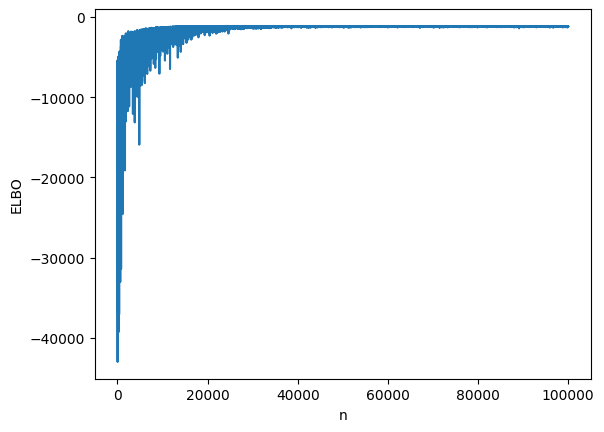

In [31]:
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

Text(0.5, 1.0, 'Std track')

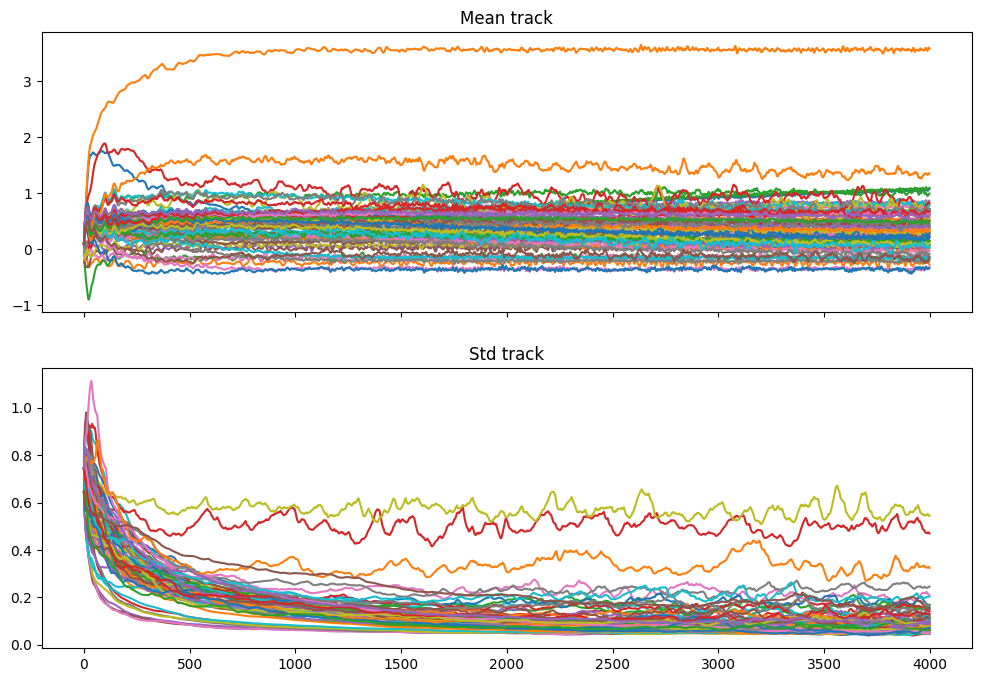

In [32]:
with grade_model:
    #Variational fit with SVGD
    advi_approx = pm.ADVI(n_particles=500, jitter=1)
#create tracker to check convergence
tracker = pm.callbacks.Tracker(
    mean=advi_approx.approx.mean.eval,  # callable that returns mean
    std=advi_approx.approx.std.eval,  # callable that returns std
)

#fit model and keep track of mean and std to check for convergence
approx = advi_approx.fit(4000,
                         callbacks=[tracker],
                         obj_optimizer=pm.adamax(learning_rate=0.1))

#plot convergence plots
fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(12, 8))
ax1.plot(tracker["mean"])
ax1.set_title("Mean track")
ax2.plot(tracker["std"])
ax2.set_title("Std track")

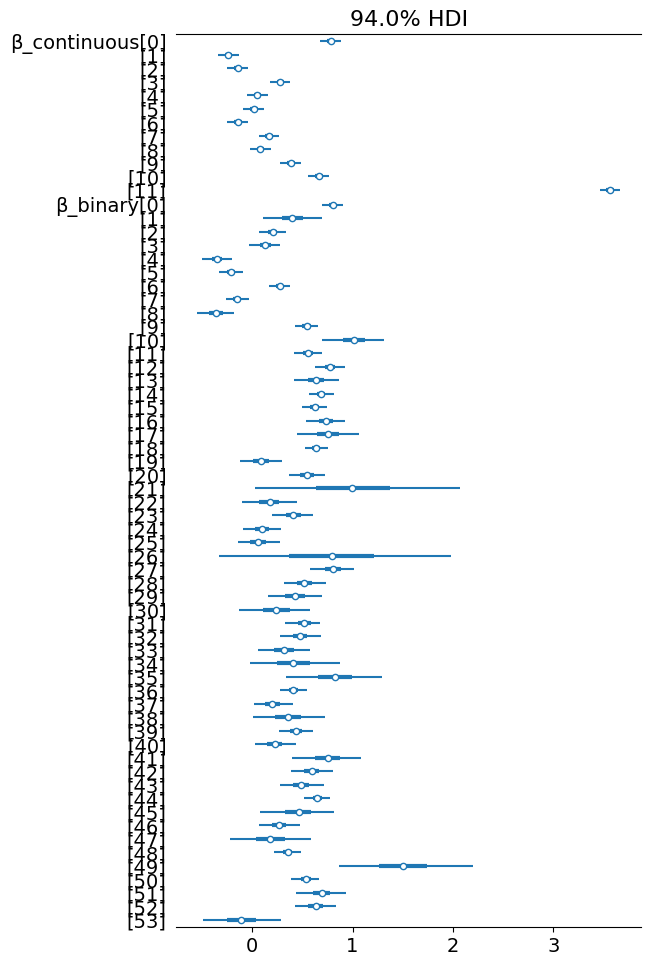

In [33]:
grade_advi_trace = advi_fit.sample(5000)
with grade_model:
    az.plot_forest(grade_advi_trace)

Sort variables based on summary statistic

In [34]:
summary = az.summary(grade_advi_trace, round_to=2)
sorting_statistic = 'mean'
sorted_variables = summary[sorting_statistic].sort_values(ascending=False).index
sorted_variables

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


Index(['β_continuous[11]', 'β_binary[49]', 'β_binary[10]', 'β_binary[21]',
       'β_binary[35]', 'β_binary[27]', 'β_binary[0]', 'β_binary[26]',
       'β_binary[12]', 'β_continuous[0]', 'β_binary[17]', 'β_binary[41]',
       'β_binary[16]', 'β_binary[51]', 'β_binary[14]', 'β_continuous[10]',
       'β_binary[44]', 'β_binary[18]', 'β_binary[52]', 'β_binary[13]',
       'β_binary[15]', 'β_binary[42]', 'β_binary[20]', 'β_binary[11]',
       'β_binary[50]', 'β_binary[9]', 'β_binary[28]', 'β_binary[31]',
       'β_binary[43]', 'β_binary[32]', 'β_binary[45]', 'β_binary[39]',
       'β_binary[29]', 'β_binary[36]', 'β_binary[23]', 'β_binary[34]',
       'β_binary[1]', 'β_continuous[9]', 'β_binary[38]', 'β_binary[48]',
       'β_binary[33]', 'β_continuous[3]', 'β_binary[46]', 'β_binary[6]',
       'β_binary[30]', 'β_binary[40]', 'β_binary[37]', 'β_binary[2]',
       'β_binary[47]', 'β_binary[22]', 'β_continuous[7]', 'β_binary[3]',
       'β_binary[24]', 'β_binary[19]', 'β_continuous[8]', 'β_bi

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (66) in plot_posterior, generating only 40 plots
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


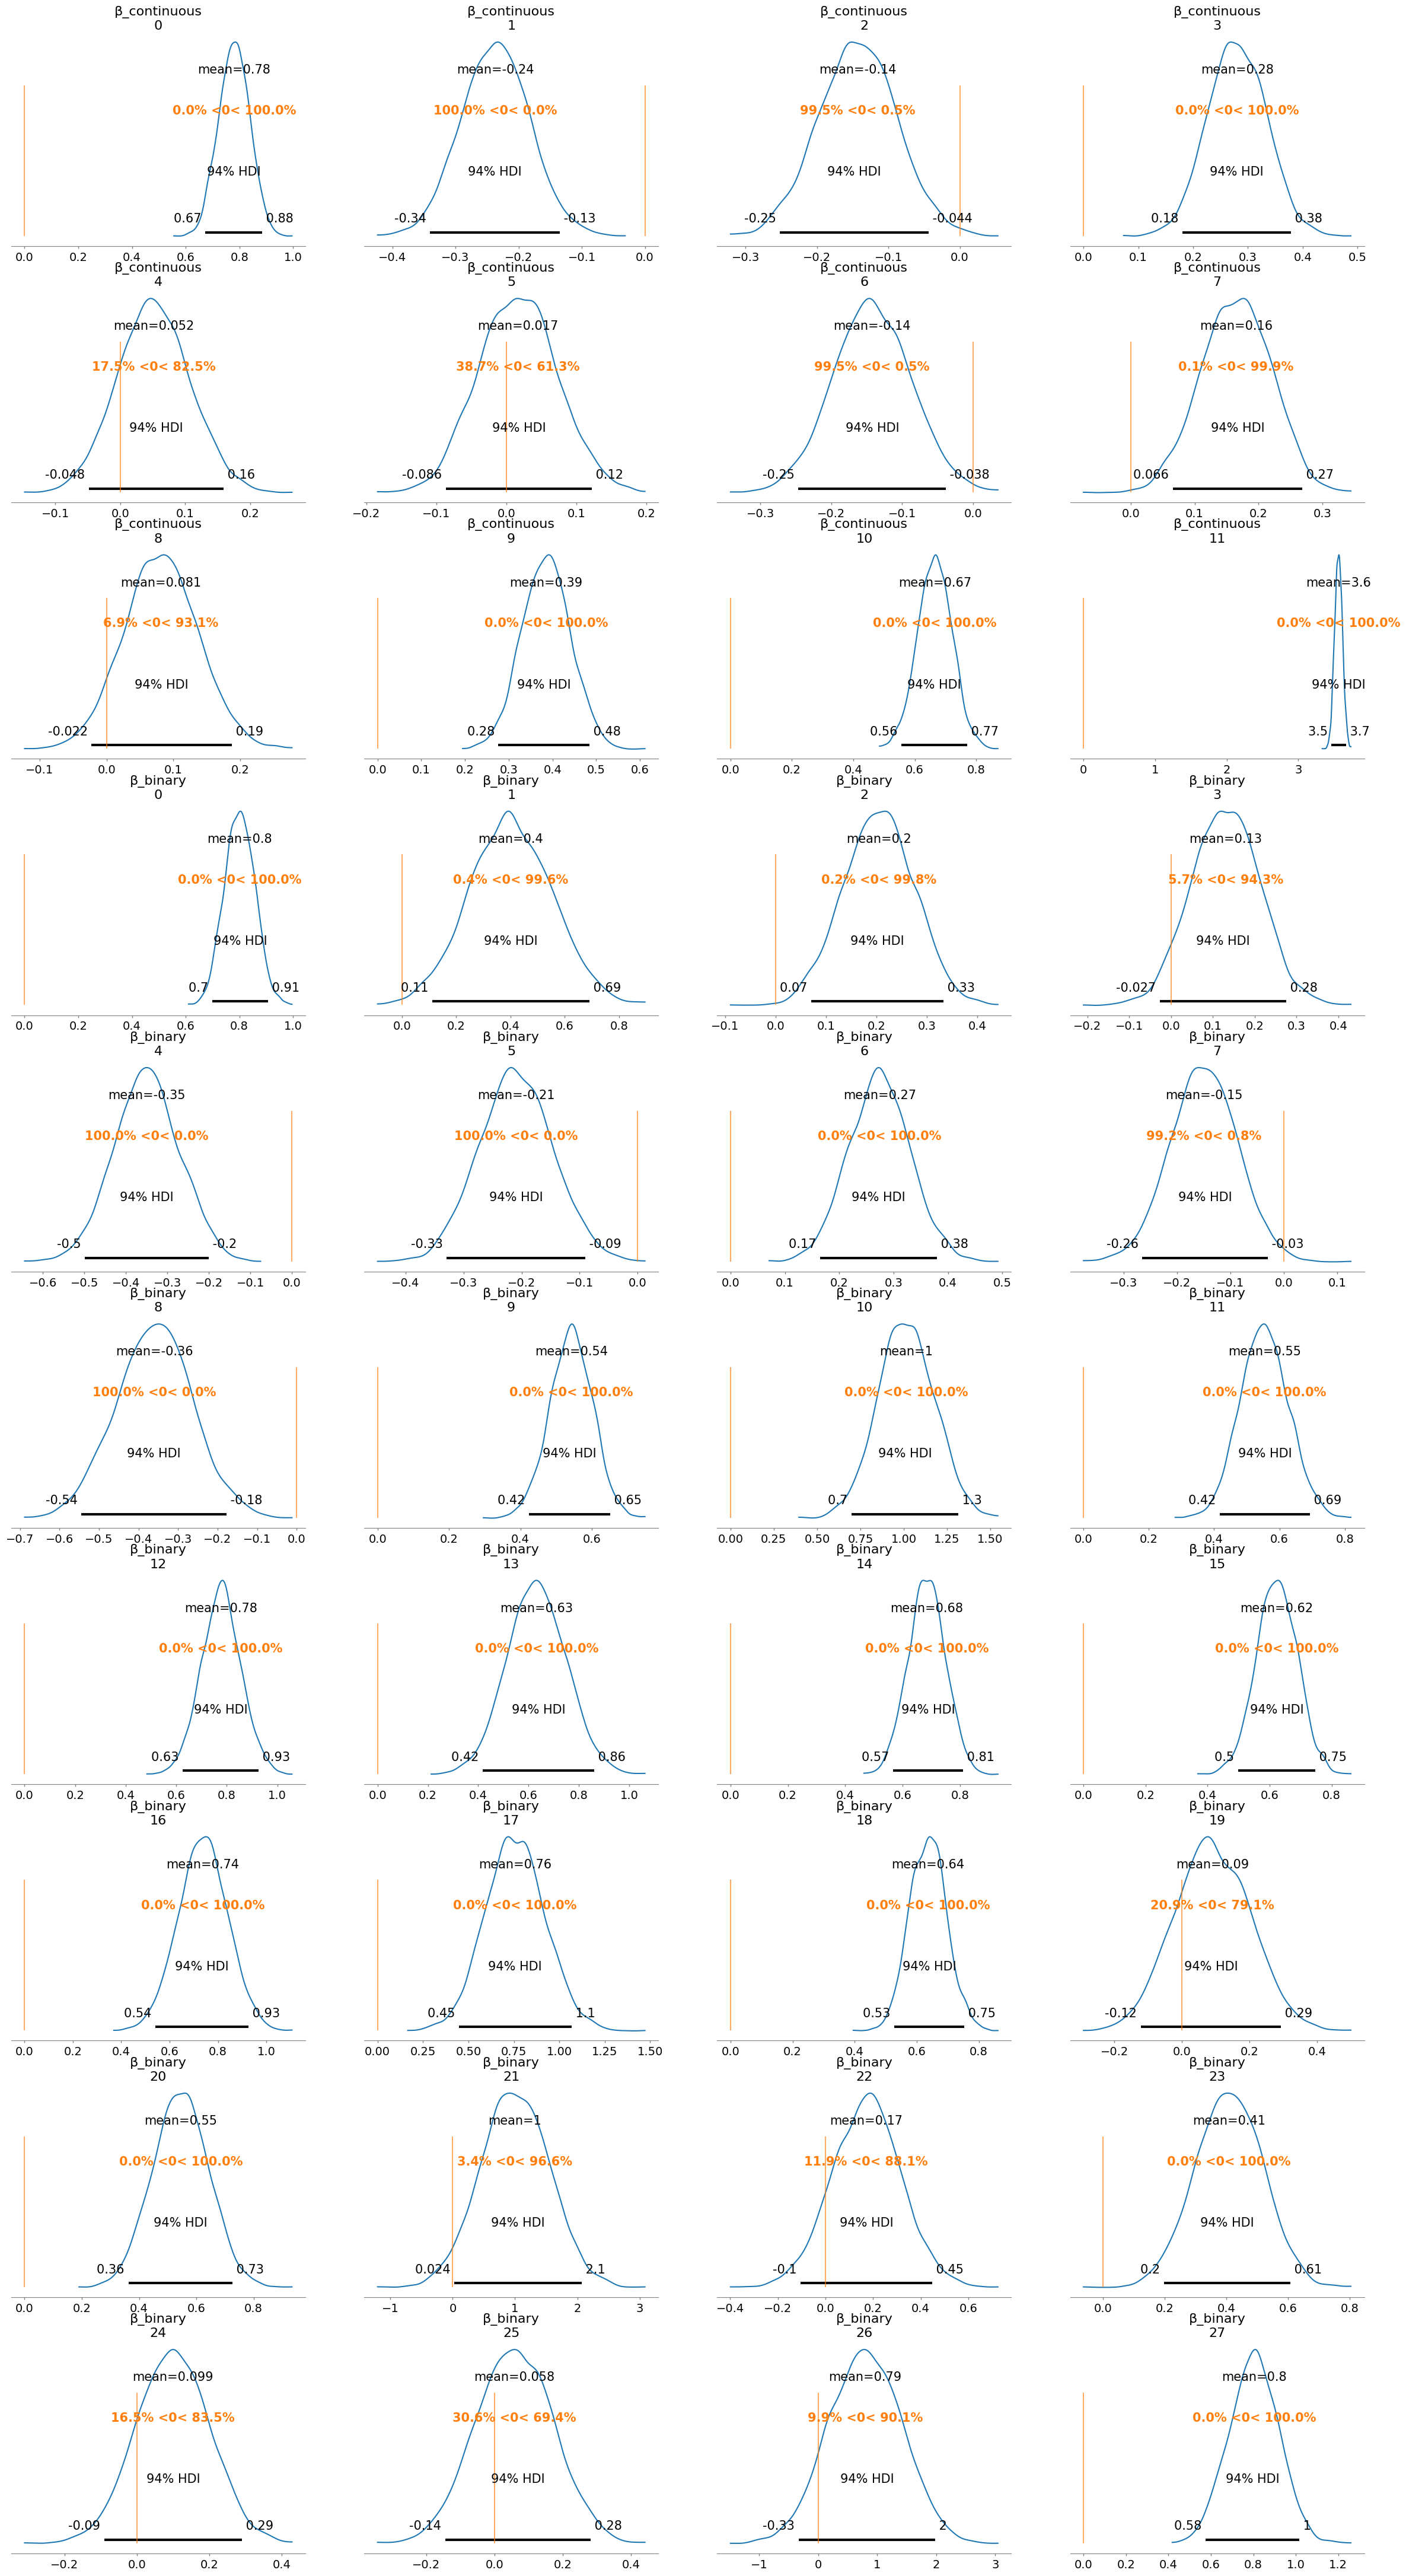

In [35]:
az.plot_posterior(
    grade_advi_trace, ref_val = 0
);

# Reduced Model

signficiant predictors

In [36]:
significant_predictors = ['grade_2',
                           'travel_time_greater_1_hour',
                           'school_MS',
                           'mother_education_none',
                           'father_job_other',
                           'father_education_primary_education_4th_grade',
                           'father_education_none',
                           'sex_M',
                           'parent_status_Apart']

# signficiant binary predictors
significant_cat = ['travel_time_greater_1_hour',
                           'school_MS',
                           'mother_education_none',
                           'father_job_other',
                           'father_education_primary_education_4th_grade',
                           'father_education_none',
                           'sex_M',
                           'parent_status_Apart']

# significant integer predictors
significant_int = ['grade_2']

In [37]:
dummies_2_cat_reduced = dummies_2_cat[significant_cat]

In [38]:
X_int_reduced = dummies_2_int[significant_int]

In [39]:
X_cat_reduced = dummies_2_cat_reduced
k_cat_reduced = X_cat_reduced.shape[1]
n_cat_reduced = X_cat_reduced.shape[0]
Ones_cat_reduced = np.ones(n_cat_reduced).reshape((n_cat_reduced,1))
X_cat_reduced = np.concatenate((Ones_cat_reduced, X_cat_reduced), axis = 1)

In [40]:
with pm.Model() as grade_model_reduced:
    β_continuous = pm.StudentT('β_continuous', nu=3, mu=0, lam=1, shape=X_int_reduced.shape[1])
    β_binary = pm.Normal('β_binary', mu=0, sigma=1, shape=X_cat_reduced.shape[1])

    # Combine beta coefficients
    β = pm.math.concatenate([β_continuous, β_binary])

    # Calculate the linear combination
    μ = pm.math.dot(X_int_reduced, β[:X_int_reduced.shape[1]]) + pm.math.dot(X_cat_reduced, β[X_int_reduced.shape[1]:])

    # Define the likelihood (normal distribution for continuous response)
    y_obs = pm.Normal('y_obs', mu=μ, sigma=1, observed=response)


g = pm.model_to_graphviz(grade_model_reduced)
g.render()

'.gv.pdf'

In [41]:
with grade_model_reduced:
    # Variational fit with ADVI optimization
    advi_fit_reduced = pm.fit(100000, method='advi', random_seed = 123)

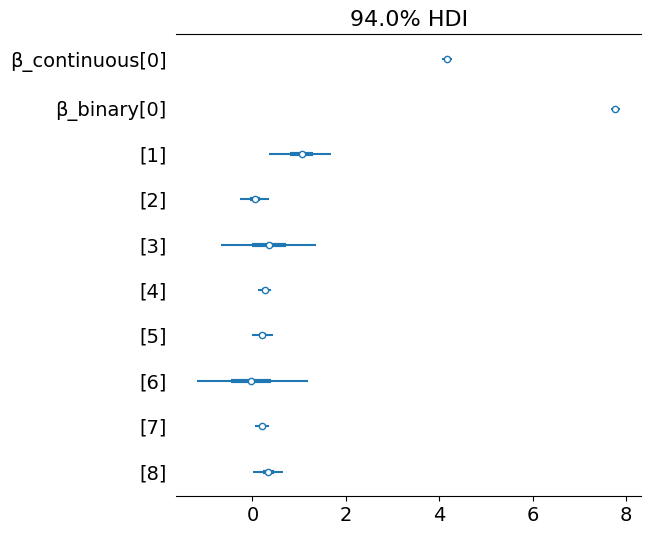

In [42]:
grade_advi_trace_reduced = advi_fit_reduced.sample(5000)

with grade_model_reduced:
    az.plot_forest(grade_advi_trace_reduced)

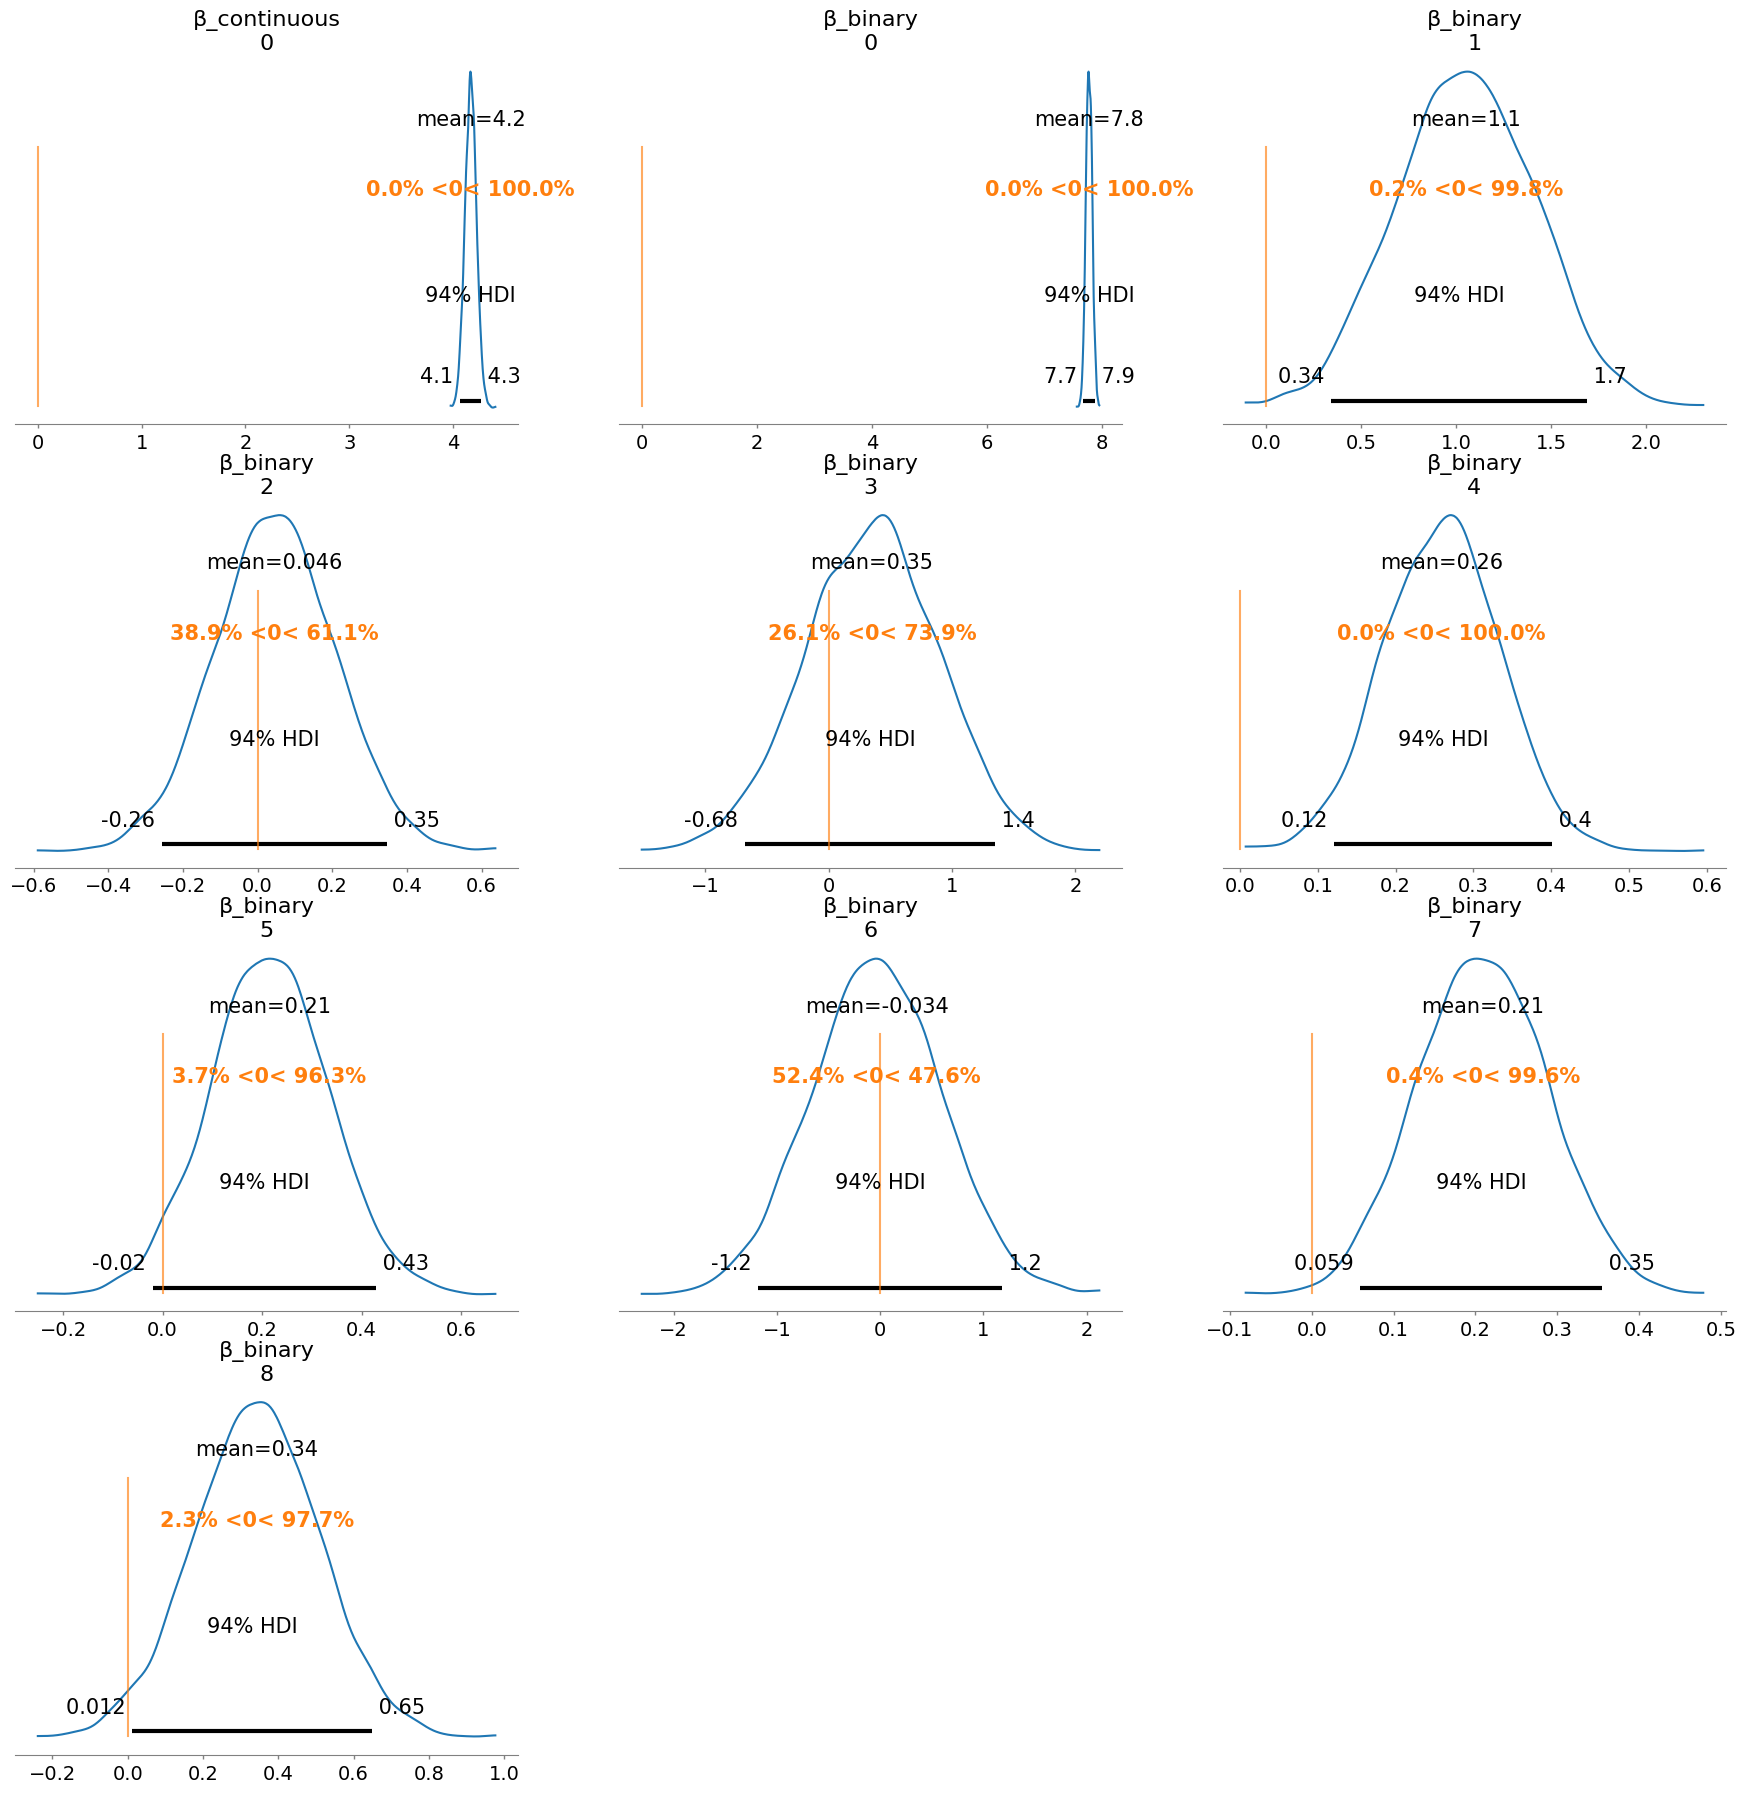

In [43]:
az.plot_posterior(
    grade_advi_trace_reduced, ref_val = 0
);

In [44]:
summary_reduced = az.summary(grade_advi_trace_reduced, round_to=2)
sorted_variables_reduced = summary_reduced[sorting_statistic].sort_values(ascending=False).index
sorted_variables_reduced

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


Index(['β_binary[0]', 'β_continuous[0]', 'β_binary[1]', 'β_binary[3]',
       'β_binary[8]', 'β_binary[4]', 'β_binary[5]', 'β_binary[7]',
       'β_binary[2]', 'β_binary[6]'],
      dtype='object')

## Prior/Posterior Predictive Checks

In [45]:
# full model
with grade_model:
  full_prior = pm.sample_prior_predictive(return_inferencedata=True)
  full_post = pm.sample_posterior_predictive(grade_advi_trace)

In [46]:
# reduced prior
with grade_model_reduced:
  reduced_prior = pm.sample_prior_predictive(return_inferencedata=True)
  reduced_post = pm.sample_posterior_predictive(grade_advi_trace_reduced)

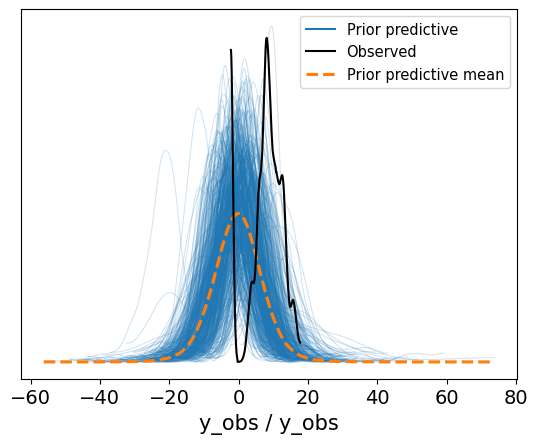

In [47]:
az.plot_ppc(full_prior, group='prior');

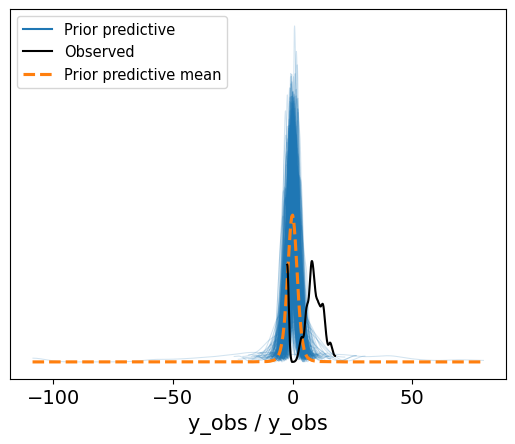

In [48]:
az.plot_ppc(reduced_prior, group='prior');

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


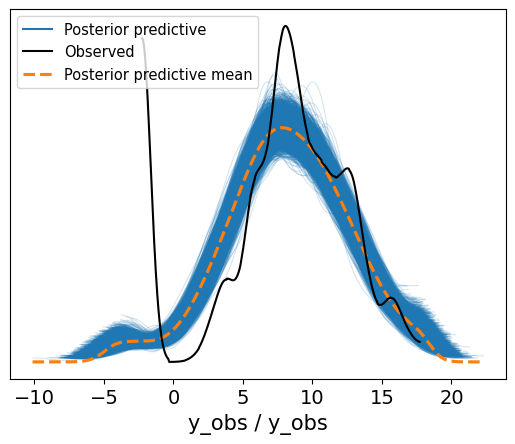

In [49]:
az.plot_ppc(full_post);

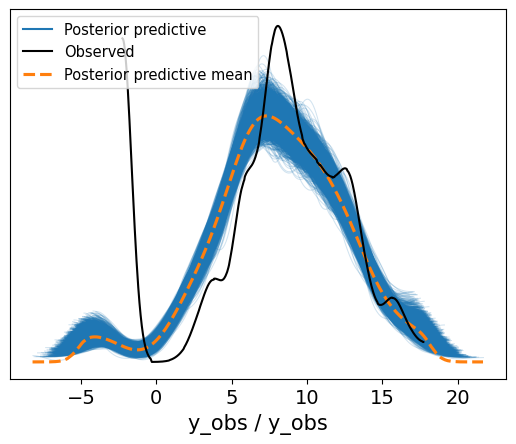

In [50]:
az.plot_ppc(reduced_post);

In [51]:
# full model
with grade_model:
  pm.compute_log_likelihood(grade_advi_trace)

In [52]:
# reduced model
with grade_model_reduced:
  pm.compute_log_likelihood(grade_advi_trace_reduced)

In [53]:
# loo
cmp_loo = az.compare({'Full': grade_advi_trace, 'Reduced': grade_advi_trace_reduced}, ic = 'loo')
cmp_loo

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Reduced,0,-1118.506045,27.979702,0.000000,0.75568,119.834236,0.000000,False,log
Full,1,-1165.964282,258.560837,47.458237,0.24432,98.392216,39.175538,True,log


In [54]:
# WAIC - measuring uncertiainty in the posterior
cmp_waic = az.compare({'Full': grade_advi_trace, 'Reduced': grade_advi_trace_reduced}, ic = 'waic')
cmp_waic

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Reduced,0,-1118.281130,27.754786,0.000000,0.749937,119.832181,0.000000,True,log
Full,1,-1160.835047,253.431602,42.553917,0.250063,98.454362,38.677883,True,log


## Making Predictions
First we get the posterior beta values out. The lower of the interval will be used to make the lower predictions, then the mean to make the mean predictions, and upper upper predictions.

#### Full Model

In [55]:
results = az.summary(
    grade_advi_trace
)

print(results)

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β_continuous[0]  0.780  0.058   0.672    0.885      0.001    0.001    5255.0   
β_continuous[1] -0.237  0.055  -0.340   -0.135      0.001    0.001    4900.0   
β_continuous[2] -0.143  0.055  -0.252   -0.044      0.001    0.001    4594.0   
β_continuous[3]  0.280  0.054   0.180    0.378      0.001    0.001    4891.0   
β_continuous[4]  0.052  0.055  -0.048    0.159      0.001    0.001    5040.0   
...                ...    ...     ...      ...        ...      ...       ...   
β_binary[49]     1.505  0.360   0.863    2.204      0.005    0.004    4638.0   
β_binary[50]     0.536  0.076   0.389    0.671      0.001    0.001    4990.0   
β_binary[51]     0.692  0.134   0.435    0.935      0.002    0.001    4882.0   
β_binary[52]     0.634  0.110   0.430    0.838      0.002    0.001    4809.0   
β_binary[53]    -0.109  0.210  -0.494    0.288      0.003    0.002    5020.0   

                 ess_tail  r_hat  
β_co

In [56]:
beta_results = results[['mean','hdi_3%','hdi_97%']]

In [57]:
dummies_2_int

,age,class_failures,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2
0,1.021751,-0.449374,0.062115,-0.235711,0.800464,-0.540014,-1.002518,-0.398784,0.036378,-1.780209,-1.253202
1,0.238078,-0.449374,1.177367,-0.235711,-0.097784,-0.540014,-1.002518,-0.398784,-0.213525,-1.780209,-1.519053
2,-1.329268,3.584777,0.062115,-0.235711,-0.996032,0.582646,0.550402,-0.398784,0.536185,-1.177653,-0.721500
3,-1.329268,-0.449374,-1.053136,-1.236851,-0.996032,-0.540014,-1.002518,1.039751,-0.463428,1.232570,0.873607
4,-0.545595,-0.449374,0.062115,-0.235711,-0.996032,-0.540014,-0.226058,1.039751,-0.213525,-1.478931,-0.189797
...,...,...,...,...,...,...,...,...,...,...,...
390,2.589096,2.240060,1.177367,1.766567,0.800464,2.827967,2.103322,0.320484,0.661137,-0.575098,-0.455649
391,0.238078,-0.449374,-2.168388,0.765428,1.698712,1.705307,1.326862,-1.118051,-0.338477,0.931292,1.405309
392,3.372769,3.584777,1.177367,1.766567,-0.097784,1.705307,0.550402,-0.398784,-0.338477,-0.273820,-0.721500
393,1.021751,-0.449374,0.062115,0.765428,-1.894280,1.705307,1.326862,1.039751,-0.713332,0.027458,0.341905


In [58]:
dummies_2_cat.iloc[:, 16]

0      1
1      0
2      0
3      0
4      0
      ..
390    1
391    0
392    0
393    0
394    0
Name: parent_status_Apart, Length: 395, dtype: int64

In [59]:
sorted = beta_results.sort_values(by='mean', ascending=False)
sorted.head(50)

,mean,hdi_3%,hdi_97%
β_continuous[11],3.563,3.464,3.666
β_binary[49],1.505,0.863,2.204
β_binary[10],1.015,0.699,1.315
β_binary[21],1.000,0.024,2.068
β_binary[35],0.823,0.336,1.295
β_binary[27],0.804,0.575,1.016
β_binary[0],0.801,0.698,0.907
β_binary[26],0.794,-0.328,1.981
β_continuous[0],0.780,0.672,0.885
β_binary[12],0.777,0.625,0.926


#### Reduced Model

In [60]:
results_reduced = az.summary(
    grade_advi_trace_reduced
)

print(results_reduced)

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β_continuous[0]  4.170  0.055   4.064    4.272      0.001    0.001    4762.0   
β_binary[0]      7.772  0.055   7.672    7.879      0.001    0.001    4623.0   
β_binary[1]      1.053  0.364   0.344    1.691      0.005    0.004    4586.0   
β_binary[2]      0.046  0.161  -0.257    0.348      0.002    0.002    5111.0   
β_binary[3]      0.351  0.542  -0.680    1.351      0.008    0.005    4949.0   
β_binary[4]      0.259  0.075   0.121    0.401      0.001    0.001    5403.0   
β_binary[5]      0.214  0.120  -0.020    0.430      0.002    0.001    4561.0   
β_binary[6]     -0.034  0.629  -1.179    1.181      0.009    0.006    4703.0   
β_binary[7]      0.209  0.079   0.059    0.354      0.001    0.001    4844.0   
β_binary[8]      0.342  0.169   0.012    0.650      0.002    0.002    5019.0   

                 ess_tail  r_hat  
β_continuous[0]    4789.0    NaN  
β_binary[0]        4829.0    NaN  
β_binary[1]   

In [61]:
beta_results_reduced = results_reduced[['mean','hdi_3%','hdi_97%']]
beta_results_reduced

,mean,hdi_3%,hdi_97%
β_continuous[0],4.170,4.064,4.272
β_binary[0],7.772,7.672,7.879
β_binary[1],1.053,0.344,1.691
β_binary[2],0.046,-0.257,0.348
β_binary[3],0.351,-0.680,1.351
β_binary[4],0.259,0.121,0.401
β_binary[5],0.214,-0.020,0.430
β_binary[6],-0.034,-1.179,1.181
β_binary[7],0.209,0.059,0.354
β_binary[8],0.342,0.012,0.650


## Clean Portuguese Data

In [62]:
test_data = pd.read_csv("student_portuguese_clean.csv")

In [63]:
test_data.isna().sum()

student_id               0
school                   0
sex                      0
age                      0
address_type             0
family_size              0
parent_status            0
mother_education         0
father_education         0
mother_job               0
father_job               0
school_choice_reason     0
guardian                 0
travel_time              0
study_time               0
class_failures           0
school_support           0
family_support           0
extra_paid_classes       0
activities               0
nursery_school           0
higher_ed                0
internet_access          0
romantic_relationship    0
family_relationship      0
free_time                0
social                   0
weekday_alcohol          0
weekend_alcohol          0
health                   0
absences                 0
grade_1                  0
grade_2                  0
final_grade              0
dtype: int64

In [64]:
clean_test = test_data.copy(deep=True)

In [65]:
clean_test = clean_test.replace(replace_map)
dummies_test = pd.get_dummies(clean_test, dtype=int)
dummies_test.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
dummies_test.rename(columns=lambda x: x.replace('(', ''), inplace=True)
dummies_test.rename(columns=lambda x: x.replace(')', ''), inplace=True)
dummies_test.rename(columns=lambda x: x.replace('<', 'less_'), inplace=True)
dummies_test.rename(columns=lambda x: x.replace('>', 'greater_'), inplace=True)

dummies_test_predict = dummies_test.drop('final_grade',axis=1)
dummies_test_predict = dummies_test_predict.drop('student_id',axis=1)

dummies_test_predict.shape

(649, 64)

In [66]:
int_cols = [
 'age',
 'class_failures',
 'family_relationship',
 'free_time',
 'social',
 'weekday_alcohol',
 'weekend_alcohol',
 'health',
 'absences',
 'grade_1',
 'grade_2']

In [67]:
# standardize int predictors
integer_data = dummies_test_predict[int_cols]
scaler = StandardScaler()
standardized_integer_data = pd.DataFrame(scaler.fit_transform(integer_data), columns=int_cols)
dummies_test_predict[int_cols] = standardized_integer_data

In [68]:
dummies_test_predict.shape

(649, 64)

## Actual Grades

In [69]:
actual_test_grades = dummies_test[['final_grade']]
actual_test_grades

,final_grade
0,11
1,11
2,12
3,14
4,13
...,...
644,10
645,16
646,9
647,10


## Full Model - Predict on Test Data

In [70]:
bo_cnts = beta_results.loc['β_continuous[0]']
bo_bin = beta_results.loc['β_binary[0]']

drop_index = ['β_continuous[0]', 'β_binary[0]']
preds = beta_results.drop(index=drop_index)

In [71]:
predictions_mean = np.dot(dummies_test_predict, preds[['mean']]) + bo_cnts['mean'] + bo_bin['mean']
predictions_lower = np.dot(dummies_test_predict, preds[['hdi_3%']]) + bo_cnts['hdi_3%'] + bo_bin['hdi_3%']
predictions_upper = np.dot(dummies_test_predict, preds[['hdi_97%']]) + bo_cnts['hdi_97%'] + bo_bin['hdi_97%']

predict_mean_df = pd.DataFrame(predictions_mean, columns=['prediction'])
predict_lower_df = pd.DataFrame(predictions_lower, columns=['prediction'])
predict_upper_df = pd.DataFrame(predictions_upper, columns=['prediction'])

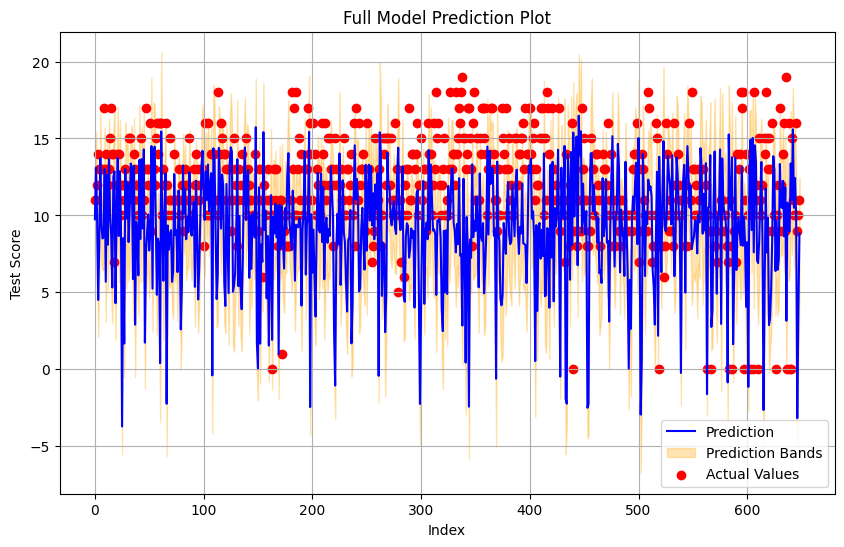

In [72]:
plt.figure(figsize=(10, 6))

# Mean predictions
plt.plot(predict_mean_df['prediction'], label='Prediction', color='blue')

# Upper and lower bounds
plt.fill_between(predict_lower_df.index, predict_lower_df['prediction'], predict_upper_df['prediction'], color='orange', alpha=0.3, label='Prediction Bands')

# Actual values
plt.scatter(actual_test_grades.index, actual_test_grades.final_grade, label='Actual Values', color='red')

plt.title('Full Model Prediction Plot')
plt.xlabel('Index')
plt.ylabel('Test Score')
plt.legend()
plt.grid(True)
plt.show()

## Reduced model

In [73]:
dummies_test_reduced = dummies_test_predict[significant_predictors]

In [74]:
dummies_test_reduced

,grade_2,travel_time_greater_1_hour,school_MS,mother_education_none,father_job_other,father_education_primary_education_4th_grade,father_education_none,sex_M,parent_status_Apart
0,-0.195820,0,0,0,0,0,0,0,1
1,-0.195820,0,0,0,1,1,0,0,0
2,0.491137,0,0,0,1,1,0,0,0
3,0.834615,0,0,0,0,0,0,0,0
4,0.491137,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
644,-0.195820,0,1,0,1,0,0,0,0
645,1.178093,0,1,0,0,1,0,0,0
646,0.147659,0,1,0,1,1,0,0,0
647,-0.539298,0,1,0,0,1,0,1,0


In [75]:
preds_reduced = beta_results_reduced.iloc[1:]

In [76]:
predictions_mean = np.dot(dummies_test_reduced, preds_reduced[['mean']]) + bo_bin['mean']
predictions_lower = np.dot(dummies_test_reduced, preds_reduced[['hdi_3%']]) + bo_bin['hdi_3%']
predictions_upper = np.dot(dummies_test_reduced, preds_reduced[['hdi_97%']]) + bo_bin['hdi_97%']

predict_mean_df = pd.DataFrame(predictions_mean, columns=['prediction'])
predict_lower_df = pd.DataFrame(predictions_lower, columns=['prediction'])
predict_upper_df = pd.DataFrame(predictions_upper, columns=['prediction'])

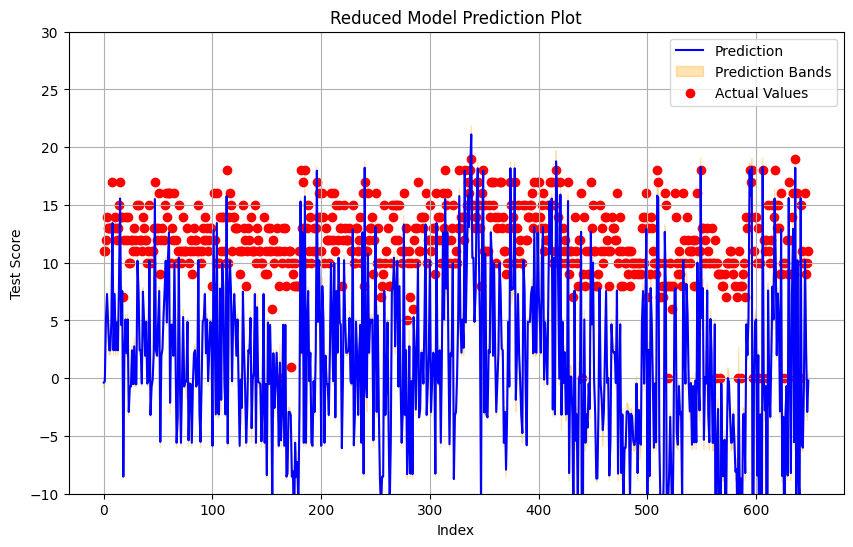

In [84]:
plt.figure(figsize=(10, 6))

# Mean predictions
plt.plot(predict_mean_df['prediction'], label='Prediction', color='blue')

# Upper and lower bounds
plt.fill_between(predict_lower_df.index, predict_lower_df['prediction'], predict_upper_df['prediction'], color='orange', alpha=0.3, label='Prediction Bands')

# Actual values
plt.scatter(actual_test_grades.index, actual_test_grades.final_grade, label='Actual Values', color='red')

plt.title('Reduced Model Prediction Plot')
plt.xlabel('Index')
plt.ylabel('Test Score')
plt.ylim(-10,30)
plt.legend()
plt.grid(True)
plt.show()

## Predictions on Math Data
For comparison/reference

In [78]:
int_columns_test = ['age',
 'class_failures',
 'family_relationship',
 'free_time',
 'social',
 'weekday_alcohol',
 'weekend_alcohol',
 'health',
 'absences',
 'grade_1',
 'grade_2',
 'final_grade']

In [79]:
# Standardize num predictors
integer_data_test = dummies_2[int_columns_test]
standardized_integer_data_test = pd.DataFrame(scaler.fit_transform(integer_data_test), columns=int_columns_test)
dummies_2[int_columns_test] = standardized_integer_data_test

In [80]:
dummies_math_predict = dummies_2.drop('final_grade',axis=1)

In [81]:
predictions_mean_math = np.dot(dummies_math_predict, preds[['mean']]) + bo_cnts['mean'] + bo_bin['mean']
predictions_lower_math = np.dot(dummies_math_predict, preds[['hdi_3%']]) + bo_cnts['hdi_3%'] + bo_bin['hdi_3%']
predictions_upper_math = np.dot(dummies_math_predict, preds[['hdi_97%']]) + bo_cnts['hdi_97%'] + bo_bin['hdi_97%']

math_mean_df = pd.DataFrame(predictions_mean_math, columns=['prediction'])
math_lower_df = pd.DataFrame(predictions_lower_math, columns=['prediction'])
math_upper_df = pd.DataFrame(predictions_upper_math, columns=['prediction'])

In [82]:
response = pd.DataFrame(response)

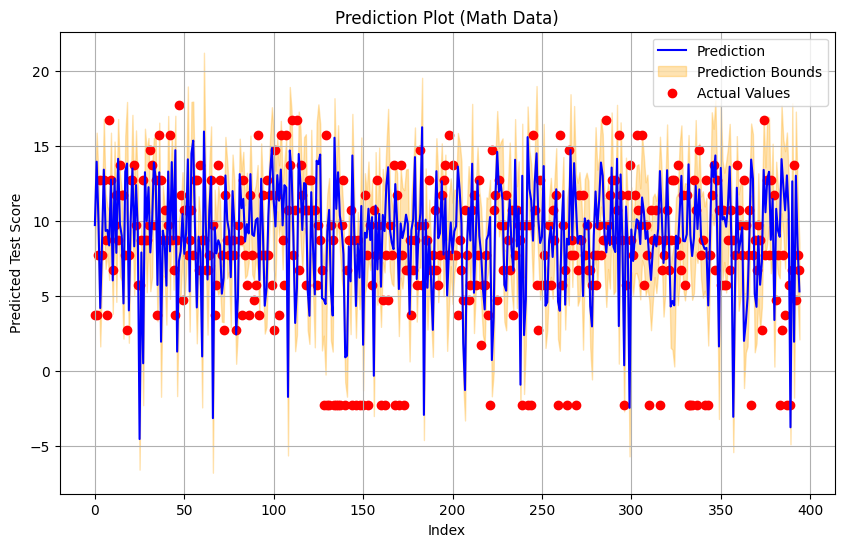

In [83]:
plt.figure(figsize=(10, 6))

# Mean predictions
plt.plot(math_mean_df['prediction'], label='Prediction', color='blue')

# Upper and lower bounds
plt.fill_between(math_lower_df.index, math_lower_df['prediction'], math_upper_df['prediction'], color='orange', alpha=0.3, label='Prediction Bounds')

# Actual values
plt.scatter(response.index, response.final_grade, label='Actual Values', color='red')

plt.title('Prediction Plot (Math Data)')
plt.xlabel('Index')
plt.ylabel('Predicted Test Score')
plt.legend()
plt.grid(True)
plt.show()